<a href="https://colab.research.google.com/github/Keshav727/eye-disease-classification/blob/main/eye_disease_classification_Main_keshav.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # visualization
import seaborn as sns # visualization
import tensorflow as tf
from tensorflow import keras
from pathlib import Path
import PIL
import os

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# import each path of the image classes
Bulging_Eyes = Path('/content/drive/MyDrive/archive.zip (Unzipped Files)/Eye_diseases/Bulging_Eyes')
Cataracts = Path('/content/drive/MyDrive/archive.zip (Unzipped Files)/Eye_diseases/Cataracts')
Crossed_Eyes = Path('/content/drive/MyDrive/archive.zip (Unzipped Files)/Eye_diseases/Crossed_Eyes')
Galaucoma = Path('/content/drive/MyDrive/archive.zip (Unzipped Files)/Eye_diseases/Glaucoma')
Uveitis = Path('/content/drive/MyDrive/archive.zip (Unzipped Files)/Eye_diseases/Uveitis')

In [5]:
# create a dataframe with the file path and the labels
disease_type = [Bulging_Eyes,Cataracts,Crossed_Eyes,Galaucoma,Uveitis]
df = pd.DataFrame()
from tqdm import tqdm
for types in disease_type:
    for imagepath in tqdm(list(types.iterdir()), desc= str(types)):
        df = pd.concat([df, pd.DataFrame({'image': [str(imagepath)],'disease_type': [disease_type.index(types)]})], ignore_index=True)

/content/drive/MyDrive/archive.zip (Unzipped Files)/Eye_diseases/Bulging_Eyes: 100%|██████████| 30/30 [00:00<00:00, 1086.35it/s]
/content/drive/MyDrive/archive.zip (Unzipped Files)/Eye_diseases/Cataracts: 100%|██████████| 47/47 [00:00<00:00, 1908.79it/s]
/content/drive/MyDrive/archive.zip (Unzipped Files)/Eye_diseases/Crossed_Eyes: 100%|██████████| 174/174 [00:00<00:00, 1669.27it/s]
/content/drive/MyDrive/archive.zip (Unzipped Files)/Eye_diseases/Glaucoma: 100%|██████████| 82/82 [00:00<00:00, 1678.85it/s]
/content/drive/MyDrive/archive.zip (Unzipped Files)/Eye_diseases/Uveitis: 100%|██████████| 50/50 [00:00<00:00, 1628.27it/s]


In [6]:
# display the dataframe
df

,image,disease_type
0,/content/drive/MyDrive/archive.zip (Unzipped F...,0
1,/content/drive/MyDrive/archive.zip (Unzipped F...,0
2,/content/drive/MyDrive/archive.zip (Unzipped F...,0
3,/content/drive/MyDrive/archive.zip (Unzipped F...,0
4,/content/drive/MyDrive/archive.zip (Unzipped F...,0
...,...,...
378,/content/drive/MyDrive/archive.zip (Unzipped F...,4
379,/content/drive/MyDrive/archive.zip (Unzipped F...,4
380,/content/drive/MyDrive/archive.zip (Unzipped F...,4
381,/content/drive/MyDrive/archive.zip (Unzipped F...,4


In [7]:
# check the count of the target label
df.disease_type.value_counts()

2    174
3     82
4     50
1     47
0     30
Name: disease_type, dtype: int64

In [8]:
 def plot_image(n, num_samples=3):
    disease_labels = ['Bulging_Eyes', 'Cataracts', 'Crossed_Eyes', 'Glaucoma', 'Uveitis']
    images = df[df['disease_type'] == n].sample(num_samples)['image']

    plt.figure(figsize=(12, 12))

    for i, path in enumerate(images, 1):
        img = (plt.imread(path) - plt.imread(path).min()) / plt.imread(path).max()
        plt.subplot(3, 3, i)
        plt.imshow(img)
        plt.axis('off')
        plt.title(disease_labels[i - 1])  # Use the current index to access the disease label

    plt.show()


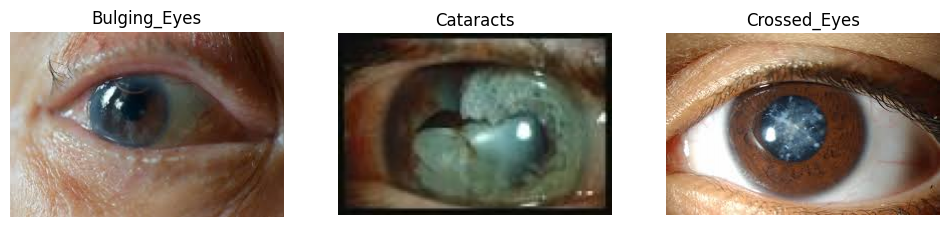

In [9]:
plot_image(1)

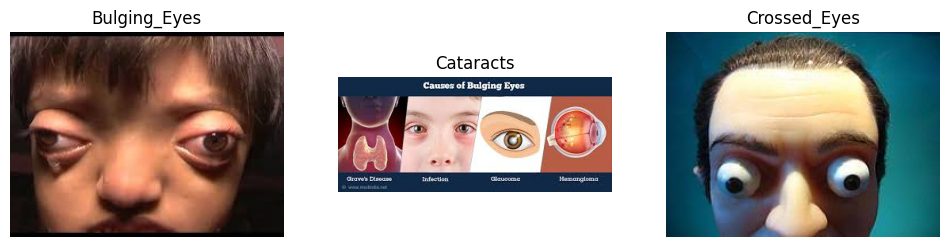

In [10]:
plot_image(0)

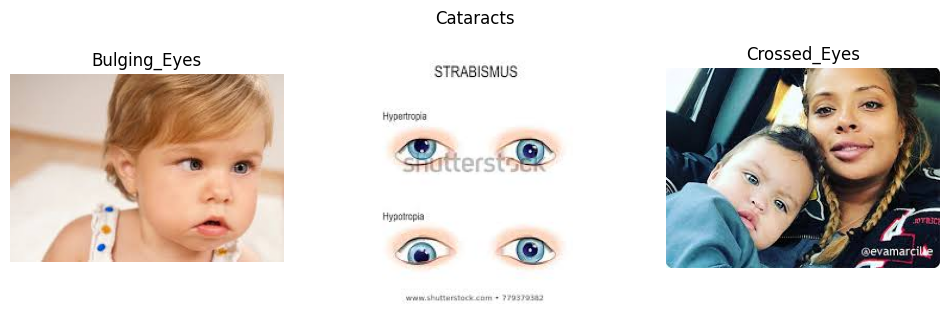

In [11]:
plot_image(2)

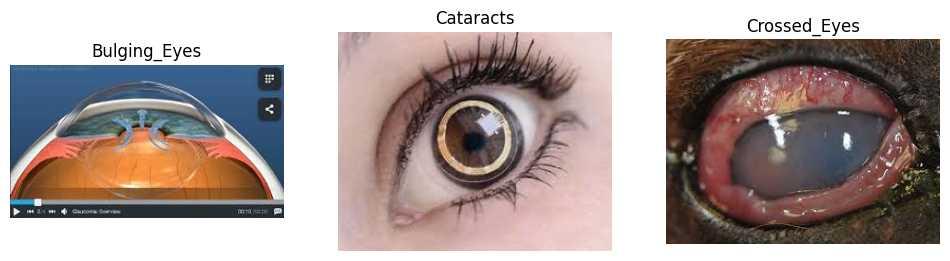

In [12]:
plot_image(3)

In [13]:
# map the labels to the disease type
df['disease_type'] = df['disease_type'].map({0:'Bulging_Eyes',1:'Cataracts',2:'Crossed_Eyes',3:'Glaucoma',4:'Uveitis'})

In [14]:
# check the lebel count to verify it has been mapped
df.disease_type.value_counts()

Crossed_Eyes    174
Glaucoma         82
Uveitis          50
Cataracts        47
Bulging_Eyes     30
Name: disease_type, dtype: int64

In [15]:
# randomising the dataset
df1 = df.sample(frac=1).reset_index(drop=True)

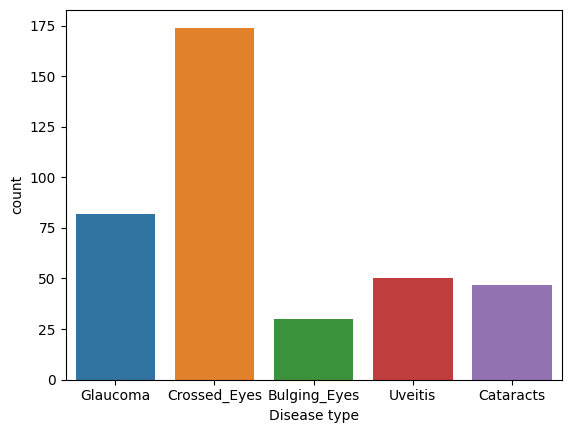

In [16]:
# create a countplot of the disease type
sns.countplot(x = 'disease_type', data = df1)
plt.xlabel("Disease type")
plt.show()

In [17]:
#import necessary libraries for the model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import classification_report, confusion_matrix

### Model Training

In [18]:
# augumentation of images
datagen = ImageDataGenerator(preprocessing_function=preprocess_input,validation_split=0.2)


In [19]:
# create the train data
train_data = datagen.flow_from_dataframe(dataframe=df1,
                                          x_col ='image',
                                          y_col = 'disease_type',
                                          target_size=(224,224),
                                          class_mode = 'categorical',
                                          batch_size = 32,
                                          shuffle = True,
                                          subset = 'training')

Found 307 validated image filenames belonging to 5 classes.


In [20]:
# create the validation data
valid_data = datagen.flow_from_dataframe(dataframe=df1,
                                          x_col ='image',
                                          y_col = 'disease_type',
                                          target_size=(224,224),
                                          class_mode = 'categorical',
                                          batch_size = 32,
                                          shuffle = False,
                                          subset = 'validation')

Found 76 validated image filenames belonging to 5 classes.


In [21]:
labels=[key for key in train_data.class_indices]
num_classes = len(disease_type)

model = keras.Sequential([
    layers.Rescaling(1./255, input_shape=(224,224, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes,activation='softmax')
])

In [22]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 64)        1

In [23]:
# fitting the model
his = model.fit(
  train_data,
    validation_data=valid_data,
  epochs=13
)

Epoch 1/13
10/10 [==============================] - 82s 8s/step - loss: 1.8373 - accuracy: 0.3290 - val_loss: 1.4674 - val_accuracy: 0.3816
Epoch 2/13
10/10 [==============================] - 1s 136ms/step - loss: 1.2758 - accuracy: 0.4886 - val_loss: 1.4124 - val_accuracy: 0.3816
Epoch 3/13
10/10 [==============================] - 2s 168ms/step - loss: 1.1229 - accuracy: 0.5407 - val_loss: 1.2962 - val_accuracy: 0.4474
Epoch 4/13
10/10 [==============================] - 2s 196ms/step - loss: 0.9416 - accuracy: 0.6678 - val_loss: 1.2713 - val_accuracy: 0.4868
Epoch 5/13
10/10 [==============================] - 1s 117ms/step - loss: 0.7037 - accuracy: 0.7394 - val_loss: 1.2351 - val_accuracy: 0.4868
Epoch 6/13
10/10 [==============================] - 1s 117ms/step - loss: 0.4846 - accuracy: 0.8599 - val_loss: 1.2279 - val_accuracy: 0.5132
Epoch 7/13
10/10 [==============================] - 1s 130ms/step - loss: 0.2730 - accuracy: 0.9153 - val_loss: 1.8384 - val_accuracy: 0.4605
Epoch 8/

### Visualizing Model Performance

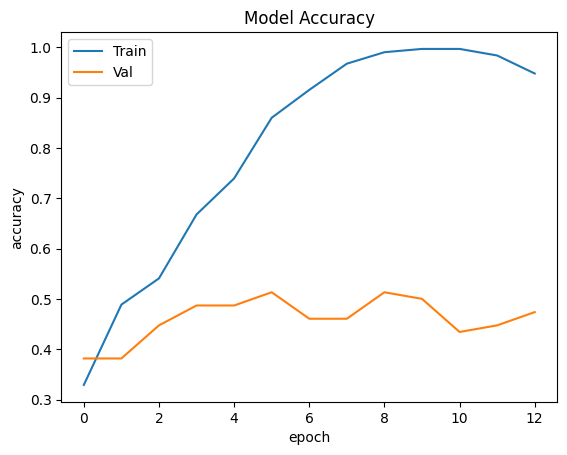

In [24]:
# create a plot of accuracy and val_acuracy for each epoch
plt.plot(his.history['accuracy'])
plt.plot(his.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'])
plt.show()

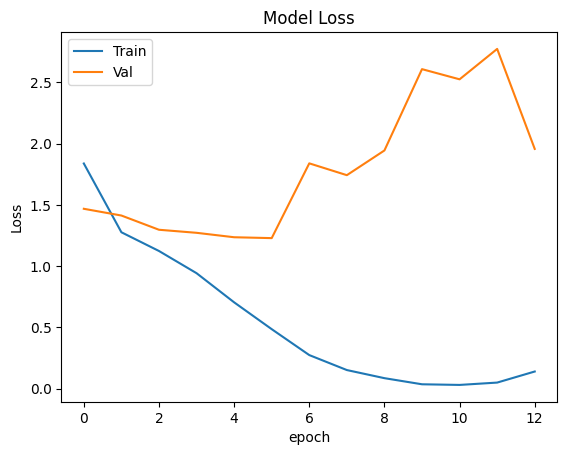

In [25]:
# create a plot of loss and val_loss for each epoch
plt.plot(his.history['loss'])
plt.plot(his.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'])
plt.show()

### Model Evaluation

In [26]:
# evaluate the model
y_test = valid_data.classes
y_pred = model.predict(valid_data)
y_pred = np.argmax(y_pred,axis=1)

3/3 [==============================] - 0s 66ms/step


In [27]:
# generate classification report of the model
print(classification_report(y_test,y_pred,target_names = labels))

              precision    recall  f1-score   support

Bulging_Eyes       0.33      0.12      0.18         8
   Cataracts       0.50      0.17      0.25        12
Crossed_Eyes       0.51      0.66      0.58        29
    Glaucoma       0.52      0.65      0.58        20
     Uveitis       0.14      0.14      0.14         7

    accuracy                           0.47        76
   macro avg       0.40      0.35      0.35        76
weighted avg       0.46      0.47      0.44        76



In [28]:
model.save("my_model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
